In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import scipy.sparse as sparse
import random
import implicit
from implicit.als import AlternatingLeastSquares as ALS

# %cd /home/user_3/medistream-recsys/Script
# from preprocessing import drop_columns,dict_to_column,dict_to_set,set_to_column,key_to_element

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

In [5]:
########### 원본
# drop columns 전처리
def drop_columns(delete_columns:list,df:pd.DataFrame) -> pd.DataFrame:
    # 회의 때 얘기한 컬럼 전처리
    # None or 필요 없는 컬럼
    df = df.drop(columns=delete_columns)
    return df

def dict_to_column(columns:list,df:pd.DataFrame) -> pd.DataFrame:
    for col in columns:
        key_set = dict_to_set(col,df)
        df = set_to_column(col,key_set,df)
    return df

def dict_to_set(column:str,df:pd.DataFrame) -> set:
    key_set = set()
    for i in tqdm(df[column]):
        
        # column 내용이 dict일 경우
        if isinstance(i, dict):
            key_set |= set(i.keys())
        
        # column 내용이 None type 일 경우
        elif i == None:
            continue
        
        # column 내용이 [dict]로 감싸져있는 경우
        elif isinstance(i, list)&len(i)>0:
            if isinstance(i[0], str):
                continue
            key_set |= set(i[0].keys())
        
    return key_set

def set_to_column(column:str,key_set:set,df:pd.DataFrame) -> pd.DataFrame:
    for key in key_set:
        
        #중복인 경우 컬럼_중복컬럼으로 추가
        if key in df.columns:
            df[column+'_'+key] = df[column].apply(lambda x: x.get(key, None) if isinstance(x, dict) else None if x==None
                                       else ( None \
                                       if len(x)==0 else ( x[0].get(key, None) \
                                       if isinstance(x[0],dict)  else \
                                           None)) \
                                      )
        #중복이 아닌 경우
        else:
            df[key] = df[column].apply(lambda x: x.get(key, None) if isinstance(x, dict) else None if x==None
                                       else ( None \
                                       if len(x)==0 else ( x[0].get(key, None) \
                                       if isinstance(x[0],dict)  else \
                                           None)) \
                                       
                                      )

    df = df.drop(columns=[column])
    return df

# 컬럼안 key 값이 한 개일 경우 딕셔너리만 풉니다!
def key_to_element(element_columns:list,df:pd.DataFrame)->pd.DataFrame:
    for col in element_columns:
        key_set = dict_to_set(col, df)
        assert len(key_set)==1, f'{col}: key가 2개 이상이므로 dict_to_column 함수 이용하세요'
        for key in key_set:
            df[col] = df[col].apply(lambda x: x.get(key,None) if isinstance(x,dict) else None)
    return df

In [6]:
df = pd.read_json('/fastcampus-data/select_column_version_3.json')

In [7]:
products_df = pd.read_json("/fastcampus-data/products/products.json")
key_to_element(['_id'],products_df)
products_df = products_df.rename(columns={'_id':'product_id'})

100%|██████████| 5141/5141 [00:00<00:00, 725755.34it/s]


In [8]:
# paid orders만 가져오기
df['date_paid'] = pd.to_datetime(df['date_paid'])
df_only_paid = df[~df['date_paid'].isna()]
# # 3개월치 데이터만 가져오기
# df_date = df_only_paid[df_only_paid['date_paid'] > "2022-05-12"]
# 취소 안된 것만 가져오기
complete_df = df_only_paid[(df_only_paid['paid'] == True) & (df_only_paid['cancelled']==False)]
complete_df = complete_df.reset_index(drop=True)
# 도서 카테고리만 가져오기
df_book = complete_df[complete_df['name'] == '도서']
df_book = df_book.sort_values(by='date_paid')

# 전체
# df_book = complete_df[complete_df['name'].isin(['도서','소모품'])].sort_values(by='date_paid')

In [9]:
# paid orders만 가져오기
df['date_paid'] = pd.to_datetime(df['date_paid'])
df_only_paid = df[~df['date_paid'].isna()]
# # 3개월치 데이터만 가져오기
df_date = df_only_paid[df_only_paid['date_paid'] > "2022-05-12"]
# 취소 안된 것만 가져오기
complete_df = df_date[(df_only_paid['paid'] == True) & (df_only_paid['cancelled']==False)]
complete_df = complete_df.reset_index(drop=True)
# 도서 카테고리만 가져오기
df_book_3month = complete_df[complete_df['name'] == '도서']
df_book_3month = df_book_3month.sort_values(by='date_paid')

# 전체
# df_book = complete_df[complete_df['name'].isin(['도서','소모품'])].sort_values(by='date_paid')

<ipython-input-9-bba5002acf8a>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  complete_df = df_date[(df_only_paid['paid'] == True) & (df_only_paid['cancelled']==False)]


# 가설: 책은 과거 데이터가 의미 있을 수 있다.
|근거|기각여부|판단사유|
|--|--|--|
|책은 한번 사면 계속해서 볼 수 있기 때문에 여러번 사지 않을 것이다. 
<br> 그렇기에 과거에 산 책도 현재 구매에 영향을 미칠 것이다.|△|전체 스테디 셀러가 시즌의 베스트셀러와 같지 않았기 때문에 근거가 될 수 없었지만 한 사람당 3권 이상 산 경우도 적지않아 보인다.<br> 하지만 1권 이상 산 경우의 수가 1권만 산 경우 대비 매우 적다.|

## bestseller

In [10]:
# 전체 베스트셀러
bestseller_money_series = df_book['price_total'].groupby(by=df_book['product_ids']).sum().sort_values(ascending=False).head(20)
bestseller_count_series = df_book['product_ids'].value_counts().head(20)
bestseller_money_df = pd.DataFrame(bestseller_money_series.reset_index().rename(columns={'product_ids':'product_id'}))
bestseller_count_df = pd.DataFrame(bestseller_count_series.reset_index().rename(columns={'index':'product_id','product_ids':'counts'}))
bestseller_count_df = pd.merge(bestseller_count_df,products_df,how='inner',left_on='product_id',right_on='product_id')
bestseller_money_df = pd.merge(bestseller_money_df,products_df,how='inner',left_on='product_id',right_on='product_id')
# 3개월 베스트 셀러
month_bestseller_money_series = df_book_3month['price_total'].groupby(by=df_book['product_ids']).sum().sort_values(ascending=False).head(20)
month_bestseller_count_series = df_book_3month['product_ids'].value_counts().head(20)
month_bestseller_money_df = pd.DataFrame(month_bestseller_money_series.reset_index().rename(columns={'product_ids':'product_id'}))
month_bestseller_count_df = pd.DataFrame(month_bestseller_count_series.reset_index().rename(columns={'index':'product_id','product_ids':'counts'}))
month_bestseller_count_df = pd.merge(month_bestseller_count_df,products_df,how='inner',left_on='product_id',right_on='product_id')
month_bestseller_money_df = pd.merge(month_bestseller_money_df,products_df,how='inner',left_on='product_id',right_on='product_id')

In [11]:
bestseller_money_list = list(bestseller_money_series.index)
bestseller_count_list = list(bestseller_count_series.index)

In [12]:
alldays_bestseller = bestseller_count_df[['name','counts']]
month_bestseller = month_bestseller_count_df[['product_id','counts','name']].rename(columns={'product_id':'3month_product_id','name':'3month_name'})

In [13]:
alldays_bestseller['total'] = len(df_book)
alldays_bestseller['percentage'] = alldays_bestseller['counts']/len(df_book)
alldays_bestseller

<ipython-input-13-d100b52ebab3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldays_bestseller['total'] = len(df_book)
<ipython-input-13-d100b52ebab3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldays_bestseller['percentage'] = alldays_bestseller['counts']/len(df_book)


,name,counts,total,percentage
0,윤상훈·권병조의 알짜 근육학,2175,38395,0.056648
1,KCD 한방내과 진찰진단 가이드라인,937,38395,0.024404
2,임상 한의사를 위한 기본 한약처방 강의 2판,847,38395,0.022060
3,한의 피부진료 첫 걸음,785,38395,0.020445
4,사상방 사용설명서,765,38395,0.019924
5,그림과 사진으로 보는 질환별 통증치료 Essential,667,38395,0.017372
6,비만문답,594,38395,0.015471
7,한방처방정석,524,38395,0.013648
8,사진으로 공부하는 이비인후과학,523,38395,0.013622
9,일차진료 한의사를 위한 보험한약입문 - 둘째 판,519,38395,0.013517


In [14]:
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]
plt.rcParams["font.family"] = 'NanumGothic'

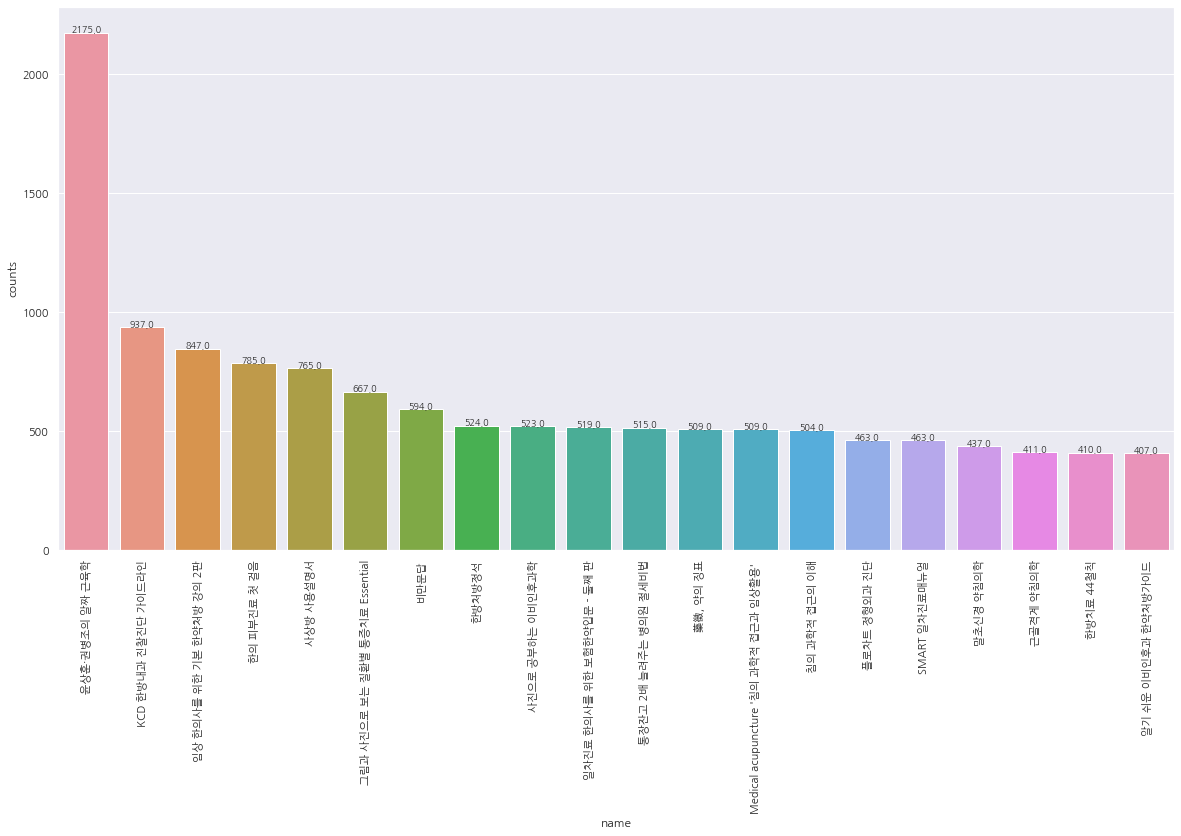

In [41]:
sns.set(rc={'figure.figsize':(15, 5)})

plt.figure(figsize=(20,10))
plt.rc('font', family='NanumGothic')
ax = sns.barplot(data=alldays_bestseller, x='name',y='counts')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

In [16]:
# bestseller 비율
bestseller_count_series.sum()/len(df_book)

0.3376481312670921

In [17]:
# 전체 베스트셀러와 최신 3개월 베스트 셀러 비교
pd.concat([alldays_bestseller,month_bestseller],axis=1)

,name,counts,total,percentage,3month_product_id,counts,3month_name
0,윤상훈·권병조의 알짜 근육학,2175,38395,0.056648,629860599d93880024071acc,594,비만문답
1,KCD 한방내과 진찰진단 가이드라인,937,38395,0.024404,62bbee3a08e04900234e36c8,463,플로차트 정형외과 진단
2,임상 한의사를 위한 기본 한약처방 강의 2판,847,38395,0.022060,62ff2f43ca740b0024397ca4,354,초음파 유도하 침 시술 가이드북
3,한의 피부진료 첫 걸음,785,38395,0.020445,6182113bbc63410023473754,324,흔히보는 정형외과 외래진료 가이드북
4,사상방 사용설명서,765,38395,0.019924,60d018b7d26af90681b18980,251,윤상훈·권병조의 알짜 근육학
5,그림과 사진으로 보는 질환별 통증치료 Essential,667,38395,0.017372,63046e9358e1680033a580d6,227,영어 진료 가이드북
6,비만문답,594,38395,0.015471,629860589d93880024071acb,215,황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼
7,한방처방정석,524,38395,0.013648,629860569d93880024071aca,201,황황교수의 개원 한의사를 위한 상한금궤 처방 강의록
8,사진으로 공부하는 이비인후과학,523,38395,0.013622,62da5dd81b3c480022189fdf,149,외래에서 꼭 알아야 할 통증증후군 137가지
9,일차진료 한의사를 위한 보험한약입문 - 둘째 판,519,38395,0.013517,62392e146f766b0024667fe2,137,카이로프랙틱 기본테크닉론


In [18]:
# 최신 3개월 베스트 셀러 안에 든 스테디 셀러
alldays_bestseller[alldays_bestseller['product_id'].isin(month_bestseller['3month_product_id'])]

KeyError: 'product_id'

In [19]:
# 사람당 팔린 책 몇권씩이나 팔렸을지? -> 대부분 3~4권을 넘지는 않았지만 25권이나 사간 이상한 사람이 있다.
multi_buyer = df_book[['customer_id','product_ids']].value_counts().reset_index()
len(multi_buyer[multi_buyer[0] > 2])

60

In [20]:
# 이상치 확인 
df_book[df_book['product_ids']=='603f3c3140a8110019dda3d3']

,_id,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
34504,603f5acc40a8110019dda3ee,2021-03-03 09:47:02.064000+00:00,5ea6931b1a3ca36b96784b03,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,20-29,1.0,0.0,False,도서,book
34355,603dca6440a8110019dda1fb,2021-03-03 09:49:10.022000+00:00,5d60cd634e77525ec5ca1402,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,40-49,1.0,1.0,False,도서,book
34507,603f5bca643a8a0019f2b98c,2021-03-03 09:50:34.412000+00:00,5d8343003f0e6805c4706733,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,30-39,1.0,1.0,False,도서,book
34505,603f5b26643a8a0019f2b983,2021-03-03 09:52:00+00:00,5d626e054e77525ec5ca15a7,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,30-39,1.0,0.0,False,도서,book
34508,603f5bcb643a8a0019f2b98e,2021-03-03 09:52:36.784000+00:00,5e15a5284267e105dfff0699,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,60-,1.0,1.0,False,도서,book
34509,603f5c91643a8a0019f2b995,2021-03-03 09:53:55.381000+00:00,5e217c7c4267e105dfff0ae5,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,30-39,1.0,1.0,False,도서,book
34518,603f5e5b643a8a0019f2b9a0,2021-03-03 10:01:47.652000+00:00,5d6dc82019efa30eb2913ef2,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,30-39,1.0,1.0,False,도서,book
34514,603f5ffa643a8a0019f2b9aa,2021-03-03 10:10:07.249000+00:00,5d6f757e19efa30eb29140cb,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,20-29,1.0,1.0,False,도서,book
34519,603f696940a8110019dda416,2021-03-03 10:49:15.853000+00:00,5d970b4f0dabe405b156dce4,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,30-39,1.0,0.0,False,도서,book
34521,603f69e840a8110019dda41e,2021-03-03 10:50:42.750000+00:00,5da03e710dabe405b156e5b0,True,"금침, 10년이 젊어진다 - 통증이 사라지고 피부가 살아나는 금실 매선",5cf8bbba0098b2225c5dfaa3,603f3c3140a8110019dda3d3,1.0,13500.0,13500.0,30-39,1.0,0.0,False,도서,book


In [21]:
len(multi_buyer[multi_buyer[0]>3])/len(multi_buyer)

0.00015845349389954048

In [22]:
# 2권보다 많이 산사람의 비중
len(multi_buyer[multi_buyer[0]>2])/len(multi_buyer)

0.001584534938995405

In [23]:
# 1권보다 많이 산사람의 비중
len(multi_buyer[multi_buyer[0]>1])/len(multi_buyer)

0.011382242645116992

In [24]:
def promotion_proprof(df):
    from datetime import datetime

    preprocessed_book_df_date = df.copy()

    promotion_book_df = preprocessed_book_df_date[preprocessed_book_df_date['date_paid'] >= '2022-01-01']
    promotion_book_df['date_paid_date'] = promotion_book_df['date_paid'].dt.date
    promotion_book_df['date_paid_week'] = promotion_book_df['date_paid_date'].apply(lambda x: x.isocalendar()[1])

    promotion_dict = {
        2:['트리거포인트 침치료'],
        3:['藥徵, 약의 징표','파킨슨병 한의진료','침의 과학적 접근의 이해','길익동동','Medical acupuncture 침의 과학적 접근과 임상활용',\
          '동의보감 약선','수화론(水火論)'],
        4:['실전한약가이드','음양승강으로 해석하는 사상의학: 생리병리'],
        5:['음양승강으로 해석하는 사상의학: 생리병리'],
        6:['윤상훈·권병조의 알짜 근육학','임상 한의사를 위한 기본 한약처방 강의 2판','트리거포인트 침치료','KCD 한방내과 진찰진단 가이드라인',\
          '실전한약가이드','음양승강으로 해석하는 사상의학: 생리병리','藥徵, 약의 징표','증보운곡본초학','통증치료를 위한 근육 초음파와 주사 테크닉'],
        7:['오국통 온병명방'],
        9:['병태생리 Visual map','NEO 인턴 핸드북','보험한약 브런치 the # 2판 개정판','Kendall 자세와 통증치료에 있어서 근육의 기능과 검사 5판',\
          '사상방 사용설명서','실전한약가이드','일차진료 한의사를 위한 보험한약입문 - 둘째 판','증보운곡본초학'],
        10:['한눈에 보는 스트레칭 해부학'],
        11:['임산부에게 사용할 수 있는 한방처방'],
        12:['임산부에게 사용할 수 있는 한방처방'],
        13:['MRI 자신감 키우기_족부편'],
        14:['장골의 PI 변위는 없다'],
        15:['윤상훈·권병조의 알짜 근육학','임상 한의사를 위한 기본 한약처방 강의 2판','KCD 한방내과 진찰진단 가이드라인','트리거포인트 침치료',\
           '음양승강으로 해석하는 사상의학: 생리병리','침의 과학적 접근의 이해','실전한약가이드','임산부에게 사용할 수 있는 한방처방','한눈에 보는 스트레칭 해부학',\
           'MRI 자신감 키우기_족부편'],
        16:['환자상담의 달인','병의원 경영과 자산 관리 클리닉','우리 병원의 문제? 현장에서 답을 찾다!','근육학','스파이랄 및 키네지오 테이핑',\
           '요양병원 주치의 진료핵심'],
        17:['오당 본초강론','운동기능장애 치료 매뉴얼','K. 한의학 임상총론','한방 활용 가이드','최강통증매선','암 치료에 이용되는 천연약물',\
           '왕문원 임상 평형침법','중국 왕문원 평형침구학'],
        18:['초음파 가이드 근골격계 통증 치료의 정석'],
        19:['초음파 가이드 근골격계 통증 치료의 정석','섭혜민 명의경방험안'],
        20:['카이로프랙틱 기본테크닉론'],
        21:['흔히보는 정형외과 외래진료 가이드북'],
        22:['趙紹琴(조소금) 내과학','한의학 상담','숨찬 세상, 호흡기를 편하게',\
         '의학심오(醫學心悟)','안면마비 침구치료','중경서 독법 강해(상,하) /개정판'],
        23:['선생님, 이제 그만 저 좀 포기해 주세요','한의학 상담','숨찬 세상, 호흡기를 편하게',\
        '의학심오(醫學心悟)','중경서 독법 강해(상,하) /개정판','안면마비 침구치료'],
     24:['황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼','황황교수의 개원 한의사를 위한 상한금궤 처방 강의록',\
        '선생님, 이제 그만 저 좀 포기해 주세요'],\
     25:['황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼',\
       '황황교수의 개원 한의사를 위한 상한금궤 처방 강의록','약침의 정석 –통증편','갑상선 진료 완전정복',\
       '신경학 증상의 감별법','이것이 알고싶다! 당뇨병진료','어지럼질환의 진단과 치료','증례와 함께 하는 한약처방',\
       '뇌의학의 첫걸음','HAPPY 소아청소년 진료'],\
     26:['약침의 정석 –통증편','갑상선 진료 완전정복','신경학 증상의 감별법',\
       '증례와 함께 하는 한약처방','이것이 알고싶다! 당뇨병진료','HAPPY 소아청소년 진료','어지럼질환의 진단과 치료',\
       '뇌의학의 첫걸음','실전, 임상한의학 내과질환을 중심으로','실전, 임상한의학 알레르기질환','침구대성','평주온열경위'],
     27:['침구과 진료매뉴얼','실전, 임상한의학 내과질환을 중심으로','실전, 임상한의학 알레르기질환','내과학 5권세트','한방순환 신경내과학',\
        '침구대성'],
     28:['감별진단의 정석','기본통증진료학','약처방의 정석 (1, 2권 세트)','QBook: Case based Review',\
         'SMART 내과 1권 : 바이탈, 감염, 종양, 류마티스','일차진료아카데미 처방가이드'],
     29:['비만문답','사암침의 해석과 임상'],
     30:['플로차트 정형외과 진단','침구과 진료매뉴얼','내과학 5권세트','한방순환 신경내과학'],
     31:['외래에서 꼭 알아야 할 통증증후군 137가지'],
     32:['SMART 기본 일차진료매뉴얼 3판(세트)','SMART 소아진료매뉴얼 3판','SMART 응급진료매뉴얼(세트)'],
     33:['SMART 기본 일차진료매뉴얼 3판(세트)','SMART 소아진료매뉴얼 3판','SMART 응급진료매뉴얼(세트)'],
     34:['초음파 유도하 침 시술 가이드북'],
     35:['영어 진료 가이드북','초음파 유도하 침 시술 가이드북'],
     36:['영어 진료 가이드북','소아피부질환해설'],
     37:['소아피부질환해설','醫學心悟(의학심오) 톺아보기'],}

    promotion_item_list = []
    for promotion_items in promotion_dict.values():
        for item in promotion_items:
            promotion_item_list.append(item)

    # set(promotion_item_list), len(set(promotion_item_list))

    preprocess_promotion_df = promotion_book_df[~((promotion_book_df['name_x'].str.contains('침의 과학적 접근과 임상활용')) & \
                            (promotion_book_df['date_paid_week']==3))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('의학심오')) & \
                                (preprocess_promotion_df['date_paid_week']==22))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('의학심오')) & \
                                (preprocess_promotion_df['date_paid_week']==23))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('약처방의 정석')) & \
                                (preprocess_promotion_df['date_paid_week']==28))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('초음파 유도하 침')) & \
                                (preprocess_promotion_df['date_paid_week']==34))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('초음파 유도하 침')) & \
                                (preprocess_promotion_df['date_paid_week']==34))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('영어 진료 가이드북')) & \
                                (preprocess_promotion_df['date_paid_week']==35))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('영어 진료 가이드북')) & \
                                (preprocess_promotion_df['date_paid_week']==36))]
    all_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('의학심오')) & \
                                (preprocess_promotion_df['date_paid_week']==37))]

    for key,value in promotion_dict.items():
        all_promotion_df = all_promotion_df[~((all_promotion_df['name_x'].isin(value)) & (all_promotion_df['date_paid_week']==key))]
    
    return all_promotion_df

In [25]:
no_promotion_book = promotion_proprof(df_book)['name_x'].value_counts()

<ipython-input-24-590bace091a5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promotion_book_df['date_paid_date'] = promotion_book_df['date_paid'].dt.date
<ipython-input-24-590bace091a5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promotion_book_df['date_paid_week'] = promotion_book_df['date_paid_date'].apply(lambda x: x.isocalendar()[1])


In [54]:
no_promotion_book_best = no_promotion_book.to_frame().rename(columns={'name_x':'counts'},)[:20]

In [55]:
no_promotion_book_best['total'] = no_promotion_book.sum()
# no_promotion_book_best['total'] = len(df_book)
no_promotion_book_best['percentage'] = no_promotion_book_best['counts']/no_promotion_book_best['total']

In [56]:
no_promotion_book_best = no_promotion_book_best.reset_index().rename(columns={'index':'name'})

In [57]:
no_promotion_book_best

,name,counts,total,percentage
0,윤상훈·권병조의 알짜 근육학,751,5886,0.127591
1,임상 한의사를 위한 기본 한약처방 강의 2판,314,5886,0.053347
2,KCD 한방내과 진찰진단 가이드라인,167,5886,0.028372
3,숲을 보는 요통치료,146,5886,0.024805
4,사상방 사용설명서,132,5886,0.022426
5,침의 과학적 접근의 이해,124,5886,0.021067
6,트리거포인트 침치료,116,5886,0.019708
7,일차진료 한의사를 위한 보험한약입문 - 둘째 판,114,5886,0.019368
8,흔히보는 정형외과 외래진료 가이드북,95,5886,0.016140
9,플로차트 한약치료,89,5886,0.015121


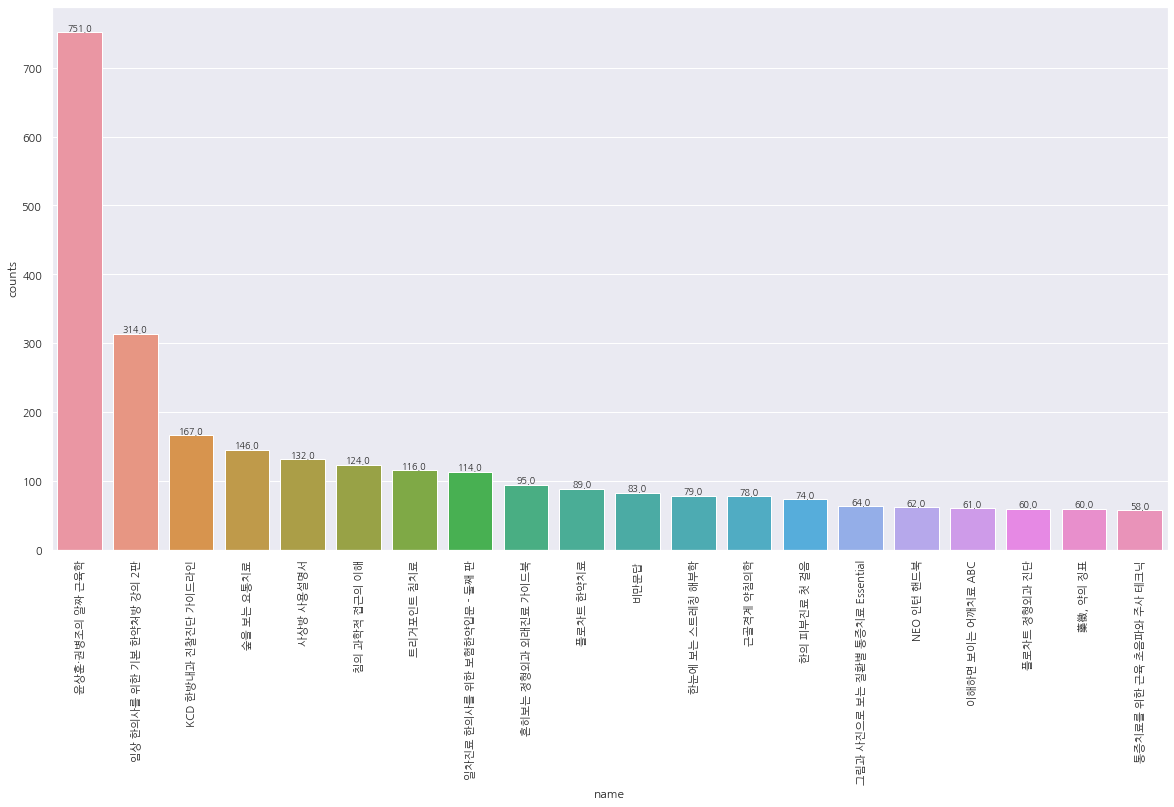

In [58]:
sns.set(rc={'figure.figsize':(15, 5)})

plt.figure(figsize=(20,10))
plt.rc('font', family='NanumGothic')
ax = sns.barplot(data=no_promotion_book_best, x='name',y='counts')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

In [29]:
len(df_book[['customer_id','product_ids']].value_counts() > 3) / len(df_book[['customer_id','product_ids']].value_counts())

1.0

In [60]:
df['name'].value_counts()

온라인 강의     73262
도서         54422
소모품        34400
한약재        22944
의료기기       12784
의약품        10071
식품          8374
의류/잡화       5331
치료실 물품      3979
가전/가구       3962
메디TV        2737
생활          2448
오프라인 강의     1471
구독          1074
해부학 모형       916
재활 용품        709
디자인          456
기타           254
약속처방         228
기획서비스         34
주류            24
Name: name, dtype: int64